## ovr-svm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import nltk
import os
import re
import pickle
import sklearn
import sys
import string

from sklearn.metrics import f1_score, precision_score, recall_score,average_precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV,ParameterGrid, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler,MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression,SGDClassifier

from tqdm import *

%load_ext autoreload
%autoreload 1

In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../../')
sys.path.append(src_dir)

In [5]:
%aimport src.data.movielens_20m_imdb
%aimport src.helpers.labels,src.helpers.neighbours, src.helpers.segments
%aimport src.utils.dataframes, src.utils.clusters, src.utils.metrics,src.utils.plotting

In [18]:
from src.data.movielens_20m_imdb import load_df_or_get_from_cache
from src.helpers.labels import truncate_labels
from src.helpers.neighbours import get_predicted_labels_from_neighbours
from src.helpers.segments import make_distance_matrix_for_segments,vectorize_segments

from src.utils.dataframes import sample_rows
from src.utils.metrics import ranking
from src.utils.plotting import plot_micro_f1_at_k

In [7]:
MODELS_ROOT = os.path.abspath("../../../models/ranking/movielens-ovr-linear-svc-calibrated/")
INTERIM_DATA_ROOT = os.path.abspath("../../../data/interim/movielens-ml20m-imdb/")
PATH_TO_PROCESSED_FILE = os.path.abspath('../../../data/processed/movielens-20m-imdb-tags-and-synopses-2017-12-20.csv')

# CONFIGS
SEED= 42

MAX_NB_WORDS = 1000

In [8]:
np.random.seed(SEED)

In [9]:
docs_df = load_df_or_get_from_cache(PATH_TO_PROCESSED_FILE,INTERIM_DATA_ROOT)

In [10]:
labels = docs_df["tags"].map(lambda tagstring: tagstring.split(","))

In [11]:
mlb = MultiLabelBinarizer()

binary_labels = mlb.fit_transform(labels)

print("total number of unique tags: {} ".format(len(mlb.classes_)))

data = docs_df['synopsis'].values
indices = np.arange(len(data))

np.random.shuffle(indices)

data = [data[i] for i in indices]
targets = binary_labels[indices]
num_validation_samples = int(0.15 * len(data))

X_train = data[:-num_validation_samples]
Y_train = targets[:-num_validation_samples]
X_val = data[-num_validation_samples:]
Y_val = targets[-num_validation_samples:]

print('total number of train documents: {}'.format(len(X_train)))
print('total number of validation documents: {}'.format(len(X_val)))

total number of unique tags: 2138 
total number of train documents: 5704
total number of validation documents: 1006


In [12]:
# https://github.com/scikit-learn/scikit-learn/issues/6614
class MyTfidfVectorizer(TfidfVectorizer):
    def fit_transform(self, X, y):
        result = super(MyTfidfVectorizer, self).fit_transform(X, y)
        result.sort_indices()
        return result

In [13]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    # https://stackoverflow.com/a/39712590/436721
    ('clf', OneVsRestClassifier(CalibratedClassifierCV(LinearSVC(),cv=2),n_jobs=-1)),
])

parameters = [
    { 
        "vect__max_features": [MAX_NB_WORDS]
    }
]

In [14]:
%%time

for g in ParameterGrid(parameters):
    pipeline.set_params(**g)
    
    pipeline.fit(X_train,Y_train)
    
    Y_pred_train = pipeline.predict_proba(X_train)    
    Y_pred_val = pipeline.predict_proba(X_val)

CPU times: user 53.7 s, sys: 512 ms, total: 54.2 s
Wall time: 1min 25s


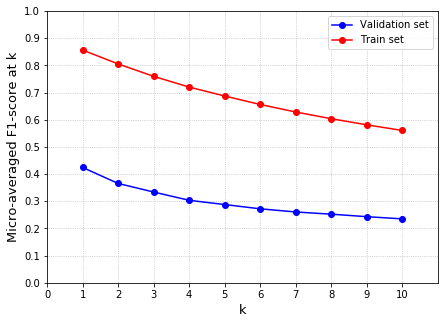

In [36]:
plt.clf()
img = plt.gcf()
ax = plt.gca()
plot_micro_f1_at_k(validation_scores,ax,train_scores)
plt.gcf().set_size_inches(7,5)
plt.show()